# Part A


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define the environment
class WumpusWorld:
    def __init__(self):
        self.grid_size = 4
        self.reset()

    def reset(self):
        self.agent_position = [0, 0]
        self.wumpus_position = [1, 2]
        self.gold_position = [2, 2]
        self.pit_positions = [[3, 0], [1, 3]]
        self.state = (self.agent_position[0], self.agent_position[1])
        return self.state

    def step(self, action):
        if action == 0:  # up
            self.agent_position[0] = max(0, self.agent_position[0] - 1)
        elif action == 1:  # down
            self.agent_position[0] = min(self.grid_size - 1, self.agent_position[0] + 1)
        elif action == 2:  # left
            self.agent_position[1] = max(0, self.agent_position[1] - 1)
        elif action == 3:  # right
            self.agent_position[1] = min(self.grid_size - 1, self.agent_position[1] + 1)

        self.state = (self.agent_position[0], self.agent_position[1])

        reward = -1  # movement penalty
        done = False

        if self.agent_position == self.gold_position:
            reward = 100
            done = True
        elif self.agent_position == self.wumpus_position:
            reward = -1000
            done = True
        elif self.agent_position in self.pit_positions:
            reward = -1000
            done = True

        return self.state, reward, done

## Q- Learning

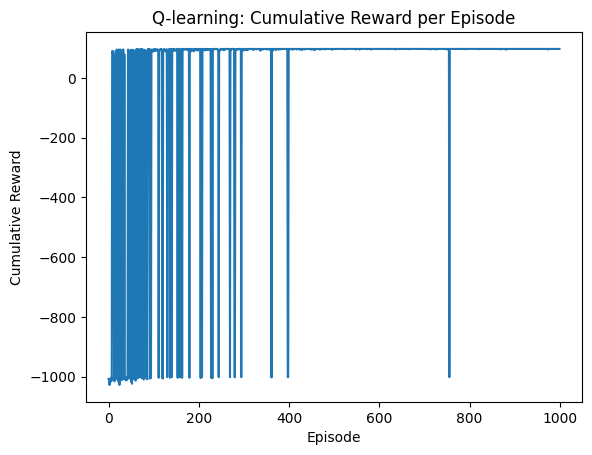

In [2]:
# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
num_episodes = 1000

# Initialize Q-table
Q_table = np.zeros((4, 4, 4))

# Training the agent
env = WumpusWorld()
rewards_per_episode = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = random.choice([0, 1, 2, 3])
        else:
            action = np.argmax(Q_table[state[0], state[1], :])

        next_state, reward, done = env.step(action)
        total_reward += reward

        best_next_action = np.argmax(Q_table[next_state[0], next_state[1], :])
        td_target = reward + discount_factor * Q_table[next_state[0], next_state[1], best_next_action]
        Q_table[state[0], state[1], action] = (1 - learning_rate) * Q_table[state[0], state[1], action] + learning_rate * td_target

        state = next_state

    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plotting the cumulative reward per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Q-learning: Cumulative Reward per Episode')
plt.show()

## DQN

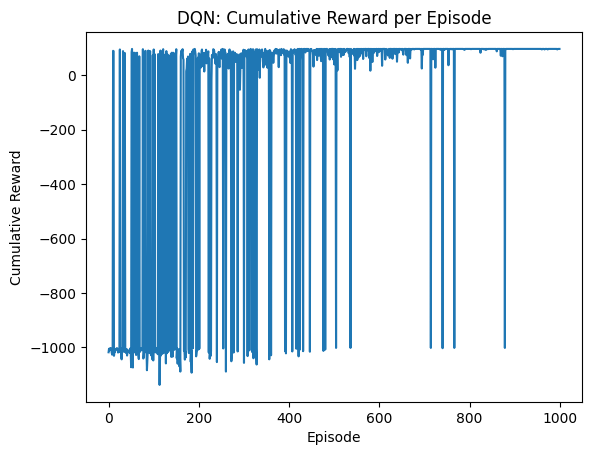

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN parameters
learning_rate = 0.001
discount_factor = 0.9
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
num_episodes = 1000
batch_size = 32
memory = []

# Initialize DQN
input_dim = 2  # State space dimension
output_dim = 4  # Action space dimension
dqn = DQN(input_dim, output_dim)
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training the agent
env = WumpusWorld()
rewards_per_episode_dqn = []

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    total_reward = 0
    done = False

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = random.choice([0, 1, 2, 3])
        else:
            q_values = dqn(state)
            action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        total_reward += reward
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        memory.append((state, action, reward, next_state, done))
        if len(memory) > 10000:
            memory.pop(0)

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
            batch_states = torch.cat(batch_states)
            batch_actions = torch.tensor(batch_actions)
            batch_rewards = torch.tensor(batch_rewards)
            batch_next_states = torch.cat(batch_next_states)
            batch_dones = torch.tensor(batch_dones, dtype=torch.float32)

            current_q_values = dqn(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)
            next_q_values = dqn(batch_next_states).max(1)[0]
            expected_q_values = batch_rewards + (1 - batch_dones) * discount_factor * next_q_values

            loss = criterion(current_q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        state = next_state

    rewards_per_episode_dqn.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# Plotting the cumulative reward per episode
plt.plot(rewards_per_episode_dqn)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('DQN: Cumulative Reward per Episode')
plt.show()


# Part B

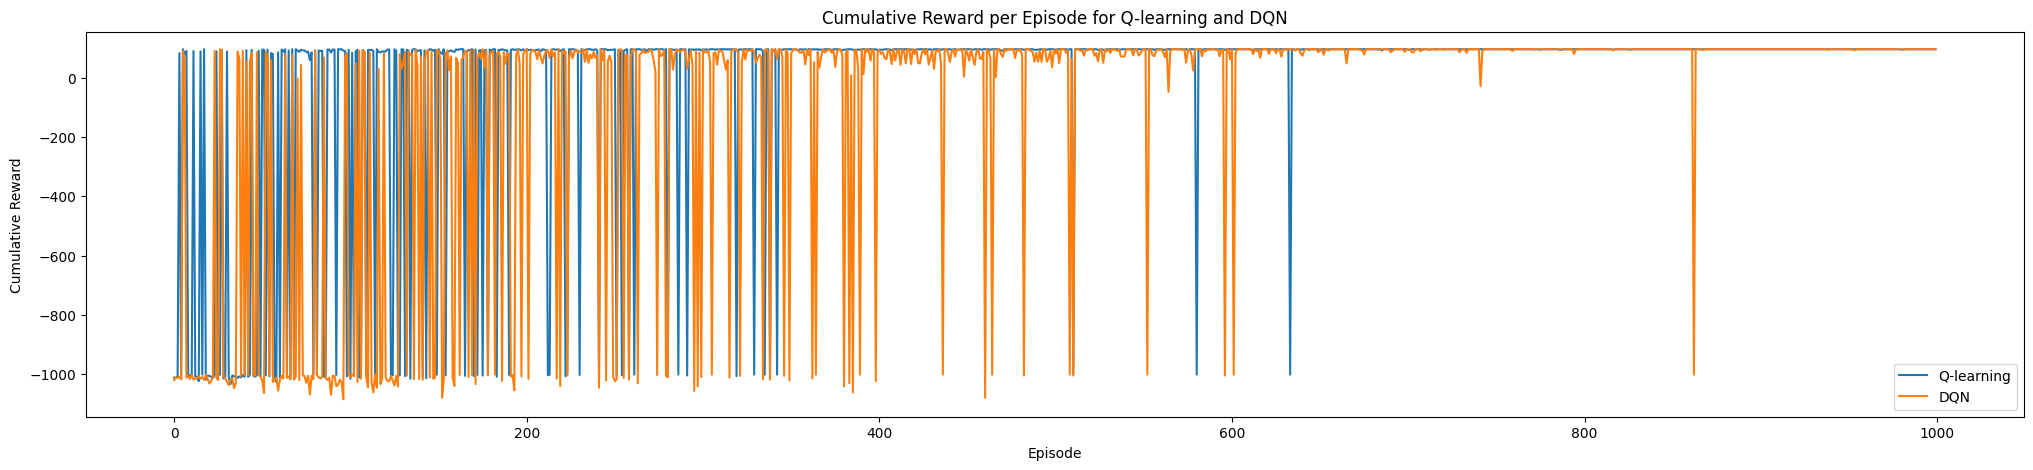

Average reward per episode for Q-learning: 96.98
Average reward per episode for DQN: 96.93


In [14]:
# Plot cumulative rewards for both Q-learning and DQN
plt.figure(figsize=(25,5))
plt.plot(rewards_per_episode, label='Q-learning')
plt.plot(rewards_per_episode_dqn, label='DQN')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward per Episode for Q-learning and DQN')
plt.legend()
plt.show()

# Calculate average reward per episode
avg_reward_q_learning = np.mean(rewards_per_episode[-100:])
avg_reward_dqn = np.mean(rewards_per_episode_dqn[-100:])

print(f'Average reward per episode for Q-learning: {avg_reward_q_learning}')
print(f'Average reward per episode for DQN: {avg_reward_dqn}')


# Part D
Count episodes required for Q-learning agent to consistently find gold

In [10]:
consistent_episodes = 0
for i in range(100, num_episodes):
    if rewards_per_episode[i] > 0:
        consistent_episodes += 1

# Compare learning efficiency
print(f'Episodes required for Q-learning agent to consistently find gold: {consistent_episodes}')


Episodes required for Q-learning agent to consistently find gold: 856


Count episodes required for DQN agent to consistently find gold

In [25]:
consistent_episodes_dqn = 0
for i in range(100, num_episodes):
    if rewards_per_episode_dqn[i] == max(rewards_per_episode_dqn):  # Episode where the agent finds gold
        consistent_episodes_dqn += 1

# Print the number of consistent episodes
print(f'Number of episodes where DQN agent consistently found gold: {consistent_episodes_dqn}')


Number of episodes where DQN agent consistently found gold: 451


Comparing

In [4]:
import numpy as np

# Calculate the moving average of rewards to smooth out the performance
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Smooth the reward data
window_size = 10
q_learning_smoothed_rewards = moving_average(rewards_per_episode, window_size)
dqn_smoothed_rewards = moving_average(rewards_per_episode_dqn, window_size)

# Determine the episode where each agent consistently gets high rewards
q_learning_threshold_episode = np.argmax(q_learning_smoothed_rewards >= 100) + window_size
dqn_threshold_episode = np.argmax(dqn_smoothed_rewards >= 100) + window_size

# Print the comparison
print(f'Q-learning agent consistently found gold starting from episode: {q_learning_threshold_episode}')
print(f'DQN agent consistently found gold starting from episode: {dqn_threshold_episode}')

# Determine which one learned the optimal policy faster
if q_learning_threshold_episode < dqn_threshold_episode:
    print('Q-learning learned the optimal policy faster.')
else:
    print('DQN learned the optimal policy faster.')


Q-learning agent consistently found gold starting from episode: 10
DQN agent consistently found gold starting from episode: 10
DQN learned the optimal policy faster.


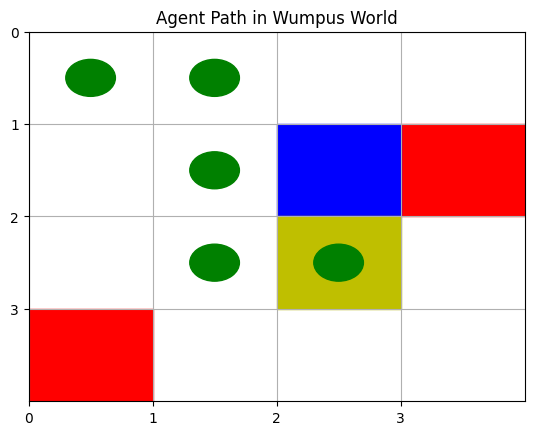

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize the route
def visualize_route(agent_path, env):
    fig, ax = plt.subplots()
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.grid(True)
    ax.invert_yaxis()  # To match the coordinate system of the environment

    # Draw the pits
    for pit in env.pit_positions:
        rect = patches.Rectangle((pit[1], pit[0]), 1, 1, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)

    # Draw the Wumpus
    wumpus = patches.Rectangle((env.wumpus_position[1], env.wumpus_position[0]), 1, 1, linewidth=1, edgecolor='b', facecolor='b')
    ax.add_patch(wumpus)

    # Draw the gold
    gold = patches.Rectangle((env.gold_position[1], env.gold_position[0]), 1, 1, linewidth=1, edgecolor='y', facecolor='y')
    ax.add_patch(gold)

    # Draw the agent's path
    for pos in agent_path:
        circle = patches.Circle((pos[1] + 0.5, pos[0] + 0.5), 0.2, color='g')
        ax.add_patch(circle)

    plt.title('Agent Path in Wumpus World')
    plt.show()

# Run a sample episode and collect the path
env = WumpusWorld()
state = env.reset()
agent_path = [env.agent_position.copy()]
done = False

while not done:
    action = np.argmax(Q_table[state[0], state[1], :])
    next_state, reward, done = env.step(action)
    agent_path.append(env.agent_position.copy())
    state = next_state

visualize_route(agent_path, env)


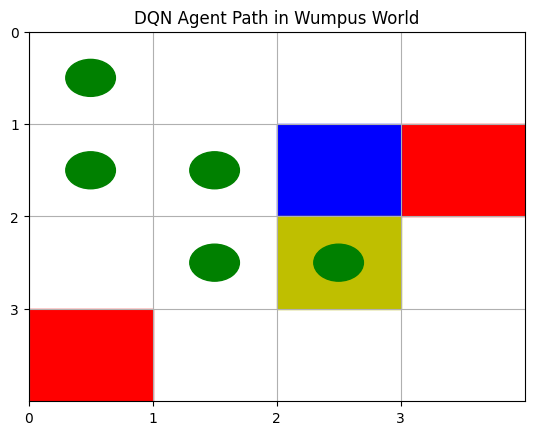

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize the route for DQN agent
def visualize_route_dqn(agent_path, env):
    fig, ax = plt.subplots()
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.grid(True)
    ax.invert_yaxis()  # To match the coordinate system of the environment

    # Draw the pits
    for pit in env.pit_positions:
        rect = patches.Rectangle((pit[1], pit[0]), 1, 1, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)

    # Draw the Wumpus
    wumpus = patches.Rectangle((env.wumpus_position[1], env.wumpus_position[0]), 1, 1, linewidth=1, edgecolor='b', facecolor='b')
    ax.add_patch(wumpus)

    # Draw the gold
    gold = patches.Rectangle((env.gold_position[1], env.gold_position[0]), 1, 1, linewidth=1, edgecolor='y', facecolor='y')
    ax.add_patch(gold)

    # Draw the agent's path
    for pos in agent_path:
        circle = patches.Circle((pos[1] + 0.5, pos[0] + 0.5), 0.2, color='g')
        ax.add_patch(circle)

    plt.title('DQN Agent Path in Wumpus World')
    plt.show()

# Run a sample episode and collect the path for DQN
env = WumpusWorld()
state = env.reset()
state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
agent_path_dqn = [env.agent_position.copy()]
done = False

while not done:
    q_values = dqn(state)
    action = torch.argmax(q_values).item()
    next_state, reward, done = env.step(action)
    agent_path_dqn.append(env.agent_position.copy())
    next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
    state = next_state

visualize_route_dqn(agent_path_dqn, env)
